In [16]:
#code ref:
#https://maziarraissi.github.io/PINNs/

In [1]:
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import OrderedDict
from tqdm import tqdm

import torch
import torch.nn as nn

In [2]:
# Multi-layer Perceptron
class NN(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size,
        output_size,
        depth,
        act=torch.nn.Tanh,
    ):
        super(NN, self).__init__()
        
        layers = [('input', torch.nn.Linear(input_size, hidden_size))]
        layers.append(('input_activation', act()))
        for i in range(depth): 
            layers.append(
                ('hidden_%d' % i, torch.nn.Linear(hidden_size, hidden_size))
            )
            layers.append(('activation_%d' % i, act()))
        layers.append(('output', torch.nn.Linear(hidden_size, output_size)))

        layerDict = OrderedDict(layers)
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

In [3]:
class Net:
    def __init__(self):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

        self.model = NN(
            input_size=2,
            hidden_size=20,
            output_size=1,
            depth=4,
            act=torch.nn.Tanh
        ).to(device)
        
        self.h = 0.1
        self.k = 0.1
        x = torch.arange(-1, 1 + self.h, self.h)
        t = torch.arange(0, 1 + self.k, self.k)

        # exact solution
        self.X = torch.stack(torch.meshgrid(x, t)).reshape(2, -1).T
        
        # training data
        bc1 = torch.stack(torch.meshgrid(x[0], t)).reshape(2, -1).T
        bc2 = torch.stack(torch.meshgrid(x[-1], t)).reshape(2, -1).T
        ic = torch.stack(torch.meshgrid(x, t[0])).reshape(2, -1).T
        self.X_train = torch.cat([bc1, bc2, ic])
        y_bc1 = torch.zeros(len(bc1))
        y_bc2 = torch.zeros(len(bc2))
        y_ic = -torch.sin(math.pi * ic[:, 0])
        self.y_train = torch.cat([y_bc1, y_bc2, y_ic])
        self.y_train = self.y_train.unsqueeze(1)
        
        self.X = self.X.to(device)
        self.X_train = self.X_train.to(device)
        self.y_train = self.y_train.to(device)
        self.X.requires_grad = True
        
        self.criterion = torch.nn.MSELoss()
        self.iter = 1
        
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-7, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe",   # better numerical stability
        )
        
        self.adam = torch.optim.Adam(self.model.parameters())
        
    def loss_func(self):
        # this is more like a not so elegant hack to zero grad both optimizers
        self.adam.zero_grad()
        self.optimizer.zero_grad()
        
        y_pred = self.model(self.X_train)
        loss_data = self.criterion(y_pred, self.y_train)
        u = self.model(self.X)

        du_dX = torch.autograd.grad(
            inputs=self.X, 
            outputs=u, 
            grad_outputs=torch.ones_like(u), 
            retain_graph=True, 
            create_graph=True
        )[0]
        
        du_dt = du_dX[:, 1]
        du_dx = du_dX[:, 0]
        du_dxx = torch.autograd.grad(
            inputs=self.X, 
            outputs=du_dX, 
            grad_outputs=torch.ones_like(du_dX), 
            retain_graph=True, 
            create_graph=True
        )[0][:, 0]
        
        loss_pde = self.criterion(du_dt + u.squeeze() * du_dx, 0.01 / math.pi * du_dxx)

        loss = loss_pde + loss_data
        loss.backward()
        if self.iter % 100 == 0: 
            print(self.iter, loss.item())
        self.iter = self.iter + 1
        return loss
    
    def train(self):
        self.model.train()
        for i in range(1000):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)
        
    def eval_(self):
        self.model.eval()

# Training

In [4]:
net = Net()
net.train()

C:\Users\mecha\anaconda3\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


100 0.18777918815612793
200 0.0967542976140976
300 0.08578500151634216
400 0.07077104598283768
500 0.06669513136148453
600 0.06396176666021347
700 0.060198429971933365
800 0.05186719447374344
900 0.03577256202697754
1000 0.026719417423009872
1100 0.009295769967138767
1200 0.005431105382740498
1300 0.0036388784646987915
1400 0.002566322684288025
1500 0.0019015477737411857
1600 0.0013643826823681593
1700 0.0010937071638181806
1800 0.0009133566054515541
1900 0.0007465980015695095
2000 0.0005781286163255572
2100 0.0004759069997817278
2200 0.0003760950348805636
2300 0.00032897235359996557
2400 0.00029087072471156716
2500 0.0002510045887902379
2600 0.00022016573348082602
2700 0.00020470678282435983
2800 0.00020292938279453665
2900 0.00017246608331333846
3000 0.00015391276974696666
3100 0.00013784482143819332
3200 0.00012046219490002841
3300 0.00011163597810082138
3400 0.00010503875091671944
3500 9.92854475043714e-05
3600 9.533743286738172e-05
3700 8.807270205579698e-05
3800 7.886957610026002

# Evaluation

In [17]:
# net.eval_()
net.model.eval()
h = 0.01
k = 0.01
x = torch.arange(-1, 1, h)
t = torch.arange(0, 1, k)

# exact solution
X = torch.stack(torch.meshgrid(x, t)).reshape(2, -1).T
X = X.to(net.X.device)

In [18]:
model = net.model
model.eval()
with torch.no_grad():
    y_pred = model(X).reshape(len(x), len(t)).cpu().numpy()

In [19]:
sns.set_style("white")

plt.figure(figsize=(5, 3), dpi=3000)

<Figure size 15000x9000 with 0 Axes>

<Figure size 15000x9000 with 0 Axes>

In [20]:
y_pred

array([[ 0.00204214,  0.00155723,  0.00115392, ..., -0.00150058,
        -0.00148293, -0.00146407],
       [ 0.03344315,  0.03200454,  0.03069592, ...,  0.00614461,
         0.00610626,  0.00606957],
       [ 0.0647999 ,  0.06241718,  0.0602116 , ...,  0.01379141,
         0.0136956 ,  0.01360312],
       ...,
       [-0.09171508, -0.08923785, -0.08691494, ..., -0.02510004,
        -0.02490883, -0.02471937],
       [-0.06069633, -0.05913445, -0.057676  , ..., -0.01701722,
        -0.01687989, -0.01674375],
       [-0.02961773, -0.02897303, -0.02838138, ..., -0.00889459,
        -0.00881118, -0.00872785]], dtype=float32)

<AxesSubplot:>

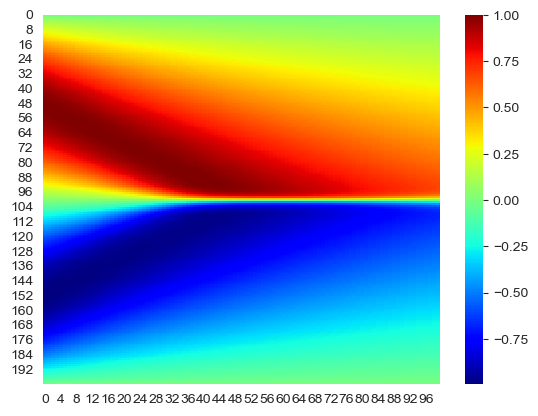

In [21]:
sns.heatmap(y_pred, cmap='jet')